In [92]:
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import math
import random
import datetime as dt
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error



Import Data

In [117]:
df = pd.read_csv('C:/Users/yolau/OneDrive/Documents/TA/Kodingan/INCO.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-18,2900.0,2950.0,2880.0,2900.0,2834.681641,8315300.0
1,2017-12-19,2940.0,2940.0,2890.0,2920.0,2854.230957,4371500.0
2,2017-12-20,2900.0,2900.0,2830.0,2850.0,2785.807617,10485500.0
3,2017-12-21,2870.0,2890.0,2840.0,2840.0,2776.032959,5395600.0
4,2017-12-22,2840.0,2850.0,2790.0,2800.0,2736.934082,4185500.0


In [118]:
df = df.dropna()

In [119]:
specific_df = df[['Date', 'Close', 'Open', 'High', 'Low']]

In [120]:
specific_df

,Date,Close,Open,High,Low
0,2017-12-18,2900.0,2900.0,2950.0,2880.0
1,2017-12-19,2920.0,2940.0,2940.0,2890.0
2,2017-12-20,2850.0,2900.0,2900.0,2830.0
3,2017-12-21,2840.0,2870.0,2890.0,2840.0
4,2017-12-22,2800.0,2840.0,2850.0,2790.0
...,...,...,...,...,...
1489,2023-12-08,4360.0,4310.0,4430.0,4310.0
1490,2023-12-11,4190.0,4360.0,4370.0,4190.0
1491,2023-12-12,4220.0,4200.0,4250.0,4180.0
1492,2023-12-13,4020.0,4220.0,4230.0,4010.0


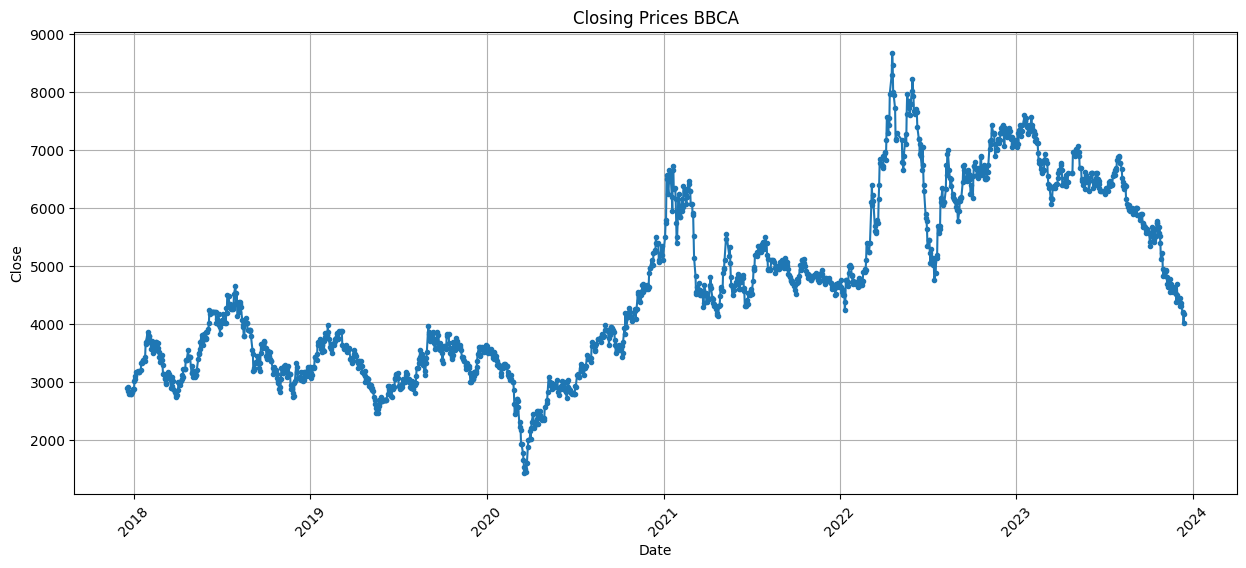

In [121]:
specific_df['Date'] = pd.to_datetime(specific_df['Date'])

plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['Close'], marker='.')
plt.title('Closing Prices BBCA')
plt.xlabel('Date')
plt.ylabel('Close')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

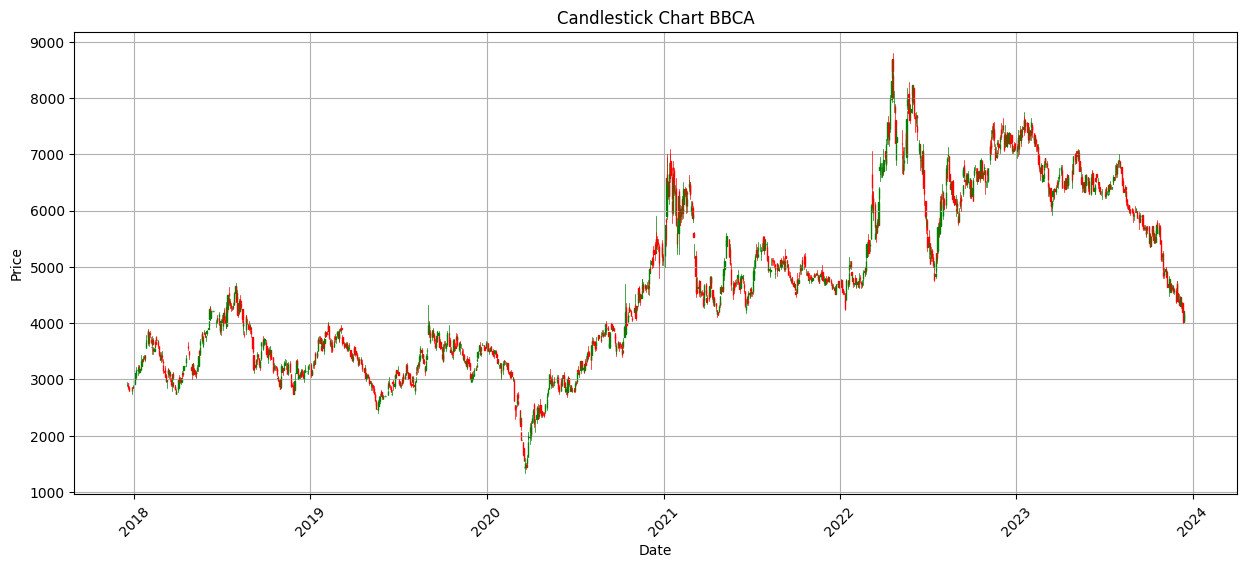

In [122]:
matplotlib_date = mdates.date2num(specific_df['Date'])

ohlc = np.vstack((matplotlib_date, specific_df['Open'], specific_df['High'], specific_df['Low'], specific_df['Close'])).T

plt.figure(figsize=(15,6))
ax = plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title('Candlestick Chart BBCA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

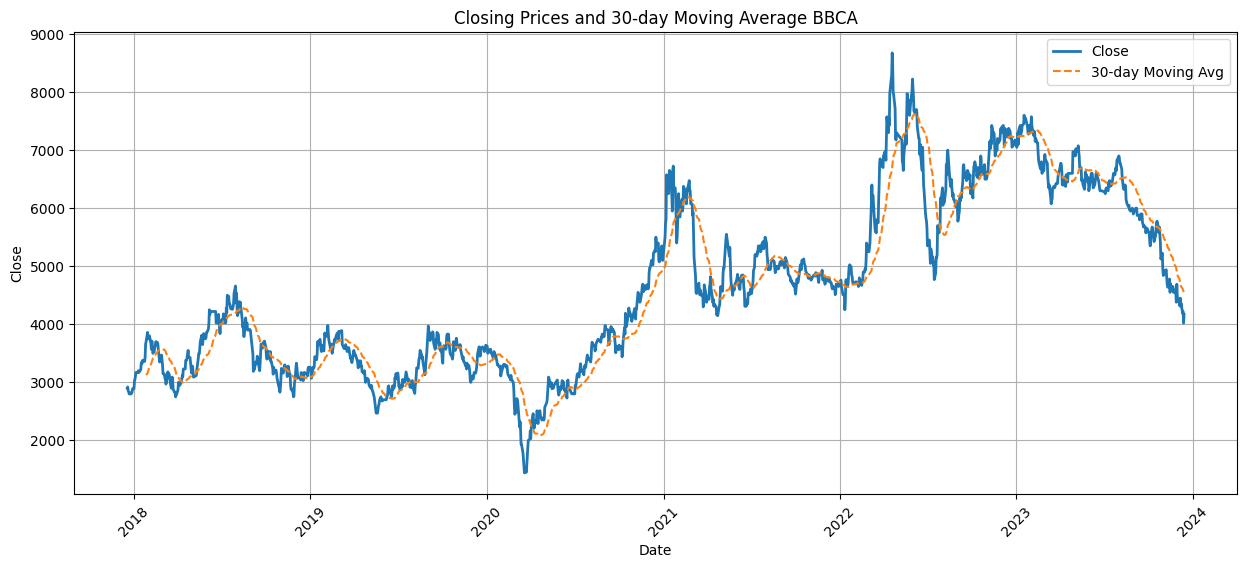

In [123]:
window = 30
plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['Close'], label='Close', linewidth=2)
plt.plot(specific_df['Date'], specific_df['Close'].rolling(window=window).mean(),label=f'{window}-day Moving Avg', linestyle='--')
plt.title(f'Closing Prices and {window}-day Moving Average BBCA')
plt.xlabel('Date')
plt.ylabel('Close')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [124]:
specific_df.head()

,Date,Close,Open,High,Low
0,2017-12-18,2900.0,2900.0,2950.0,2880.0
1,2017-12-19,2920.0,2940.0,2940.0,2890.0
2,2017-12-20,2850.0,2900.0,2900.0,2830.0
3,2017-12-21,2840.0,2870.0,2890.0,2840.0
4,2017-12-22,2800.0,2840.0,2850.0,2790.0


In [125]:
new_df = specific_df.reset_index()['Close']

In [126]:
new_df

0       2900.0
1       2920.0
2       2850.0
3       2840.0
4       2800.0
         ...  
1488    4360.0
1489    4190.0
1490    4220.0
1491    4020.0
1492    4170.0
Name: Close, Length: 1493, dtype: float64

In [127]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [128]:
data = scaled_data

top_20_data = data[:20]
print(top_20_data)

[[0.20179682]
 [0.20456116]
 [0.19488597]
 [0.1935038 ]
 [0.18797512]
 [0.18797512]
 [0.18797512]
 [0.19212163]
 [0.19212163]
 [0.20041465]
 [0.20041465]
 [0.21976503]
 [0.22252937]
 [0.23082239]
 [0.23911541]
 [0.23911541]
 [0.24049758]
 [0.24326192]
 [0.23911541]
 [0.24049758]]


Partisi Data

90%

In [129]:
train_size = int(len(scaled_data)*0.9) #90% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [130]:
n_past = 1

X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [131]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(1342, 1)
(1342,)


Testing set size:-
(149, 1)
(149,)


(None, None)

In [132]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [133]:
Layer = 3

In [134]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.6))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.6))

model.add(LSTM(units=50))
model.add(Dropout(0.6))

model.add(Dense(units=1))

In [135]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 1, 50)             10400     
                                                                 
 dropout_18 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_19 (LSTM)              (None, 1, 50)             20200     
                                                                 
 dropout_19 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_20 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_20 (Dropout)        (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                

In [136]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [137]:
checkpoints = ModelCheckpoint(filepath= 'bbca.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=150,
          batch_size=128,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/150
11/11 [==============================] - 6s 106ms/step - loss: 0.2005 - val_loss: 0.3261
Epoch 2/150
11/11 [==============================] - 0s 15ms/step - loss: 0.1631 - val_loss: 0.2573
Epoch 3/150
11/11 [==============================] - 0s 15ms/step - loss: 0.1156 - val_loss: 0.1604
Epoch 4/150
11/11 [==============================] - 0s 13ms/step - loss: 0.0593 - val_loss: 0.0495
Epoch 5/150
11/11 [==============================] - 0s 14ms/step - loss: 0.0330 - val_loss: 0.0100
Epoch 6/150
11/11 [==============================] - 0s 11ms/step - loss: 0.0362 - val_loss: 0.0245
Epoch 7/150
11/11 [==============================] - 0s 10ms/step - loss: 0.0315 - val_loss: 0.0305
Epoch 8/150
11/11 [==============================] - 0s 10ms/step - loss: 0.0291 - val_loss: 0.0194
Epoch 9/150
11/11 [==============================] - 0s 10ms/step - loss: 0.0267 - val_loss: 0.0138
Epoch 10/150
11/11 [==============================] - 0s 10ms/step - loss: 0.0231 - val_loss: 0.019

In [138]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

5/5 [==============================] - 0s 0s/step


In [114]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [139]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.022365577544260714
0.01906684733508393


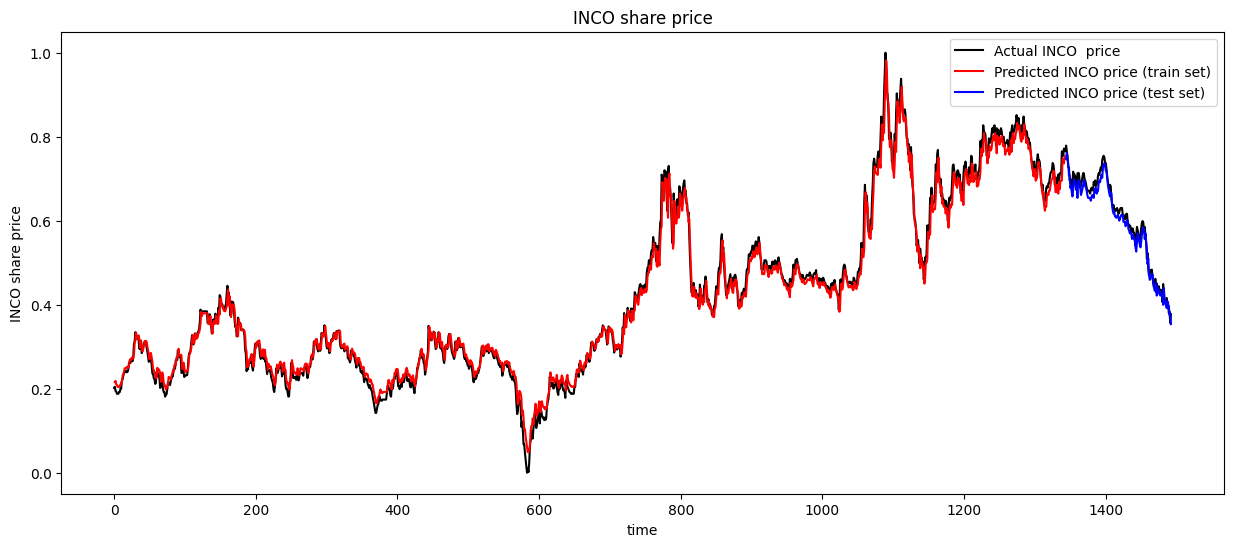

In [140]:
look_back = 1

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual INCO  price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted INCO price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted INCO price (test set)")

plt.title(f"INCO share price")
plt.xlabel("time")
plt.ylabel(f"INCO share price")
plt.legend()
plt.show()

In [ ]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 135ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 6418.84619140625
Day 2: Predicted Price = 6433.81787109375
Day 3: Predicted Price = 6445.7587890625
Day 4: Predicted Price = 6455.3115234375
Day 5: Predicted Price = 6462.97314453125
Day 6: Predicted Price = 6469.1298828125
Day 7: Predicted Price = 6474.0859375
Day 8: Predicted Price = 6478.08056640625
Day 9: Predicted Price = 6481.30322265625
Day 10: Predicted Price = 6483.9052734375
Day 11: Predicted Price = 6486.0078125
Day 12: Predicted Price = 6487.70751953125
Day 13: Predicted Price = 6489.08154296875
Day 14: Predicted Price = 6490.19384765625
Day 15: Predicted Price = 6491.09423828125
Day 16: Predicted Price = 6491.82275390625
Day 17: Predicted Price = 6492.41259765625
Day 18: Predicted Price = 6492.89013671875
Day 19: Predicted Price = 6493.27685546875
Day 20: Predicted Price = 6493.59033203125
Day 21: Predicted Price = 6493.84375
Day 22: Predicted Price = 6494.048828

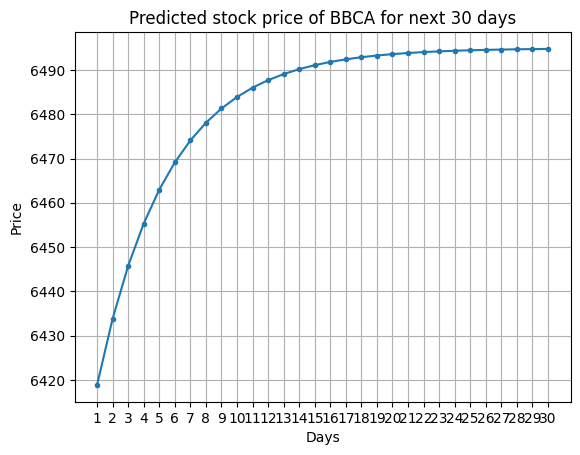

In [ ]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of BBCA for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()